____

## Intro

some explanations here -> https://docs.google.com/document/d/10CvKiVur7J61Swio6GEjbb-9AwYLhNUIp7HHUSVLB8g/edit#heading=h.xr4ou5u24jm2

____

**Imports**

In [66]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import numpy as np
from scipy import spatial
from fastdtw import fastdtw
import tensorflow as tf

from enum import Enum
import datetime
from tqdm import tqdm
import random

____

## Pose Detector

In [14]:
class Joint(Enum):
    nose = 0
    left_eye = 1
    right_eye = 2
    left_ear = 3
    right_ear = 4
    left_shoulder = 5
    right_shoulder = 6
    left_elbow = 7
    right_elbow = 8
    left_wrist = 9
    right_wrist = 10
    left_hip = 11
    right_hip = 12
    left_knee = 13
    right_knee = 14
    left_ankle = 15
    right_ankle = 16

In [15]:
VECTORS = [
    [Joint.left_shoulder, Joint.left_elbow], # left shoulder -> left elbow
    [Joint.right_shoulder, Joint.right_elbow], # right shoulder -> right elbow
    
    [Joint.left_elbow, Joint.left_wrist], # left elbow -> left wrist
    [Joint.right_elbow, Joint.right_wrist], # right elbow -> right wrist
    
    [Joint.left_shoulder, Joint.left_hip], # left shoulder -> left hip
    [Joint.right_shoulder, Joint.right_hip], # right shoulder -> right hip
    
    [Joint.left_hip, Joint.left_knee], # left hip -> left knee
    [Joint.right_hip, Joint.right_knee], # right hip -> right knee
    
    [Joint.left_knee, Joint.left_ankle], # left knee -> left ankle
    [Joint.right_knee, Joint.right_ankle], # right knee -> right ankle,
    
    [Joint.left_shoulder, Joint.right_shoulder], # left shoulder -> right shoulder
    [Joint.left_hip, Joint.right_hip], # left hip -> right hip,
]

In [20]:
class Detector:
    
    def __init__(self, model_path, img_size, draw_main_color=(0, 255, 0), draw_deviated_color=(242, 75, 26)):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.img_size = img_size
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.draw_main_color = draw_main_color
        self.draw_deviated_color = draw_deviated_color
        
        
    def get_keypoints(self, img):
        image = np.array(img)[:, :, 0:3].astype('uint8')
        image = tf.expand_dims(image, axis=0)
        image = tf.image.resize_with_pad(image, self.img_size, self.img_size)
        image = tf.cast(image, dtype=tf.uint8)
        self.interpreter.set_tensor(self.input_details[0]['index'], image.numpy())
        self.interpreter.invoke()
        keypoints_with_scores = self.interpreter.get_tensor(self.output_details[0]['index'])
        return keypoints_with_scores
    
    
    def get_positions_array(self, img):
        keypoints = self.get_keypoints(img)
        res = np.array([[x[0], x[1]] for x in keypoints[0][0]])
        return res 
    
    
    def draw_joints(self, img, positions=None, deviated=[]):
        frame = np.array(img)
        if positions == None:
            positions = self.get_positions_array(img)    
        img_height, img_width = frame.shape[0], frame.shape[1]
        if img_height > img_width:
            rat_x, rat_y = img_width / img_height, 1
        else:
            rat_y, rat_x = img_height / img_width, 1
        for (i, (y, x)) in enumerate(positions):
            color = (i in deviated) and self.draw_deviated_color or self.draw_main_color
            pos_x  = int(img_width * (x - (1 - rat_x) / 2) / rat_x)
            pos_y = int(img_height * (y - (1 - rat_y) / 2) / rat_y)
            cv2.circle(frame, (pos_x, pos_y), 5, color, thickness=-1)
        return frame
    

    def draw_vectors(self, img, positions=None, deviated=[]):
        frame = np.array(img)
        if positions == None:
            positions = self.get_positions_array(img)    
        img_height, img_width = frame.shape[0], frame.shape[1]
        if img_height > img_width:
            rat_x, rat_y = img_width / img_height, 1
        else:
            rat_y, rat_x = img_height / img_width, 1
        real_positions = []
        for (y, x) in positions:
            x = int(img_width * (x - (1 - rat_x) / 2) / rat_x)
            y = int(img_height * (y - (1 - rat_y) / 2) / rat_y)
            real_positions.append([x, y])
        for (i, (frm, to)) in enumerate(VECTORS):
            color = (i in deviated) and self.draw_deviated_color or self.draw_main_color
            cv2.line(frame, real_positions[frm.value], real_positions[to.value], thickness=3, color=color)
        return frame

____

**Examples**

In [11]:
MODEL_PATH = './data/models/movenet_thunder.tflite'
MODEL_IMG_SIZE = 256

detector = Detector(MODEL_PATH, MODEL_IMG_SIZE)

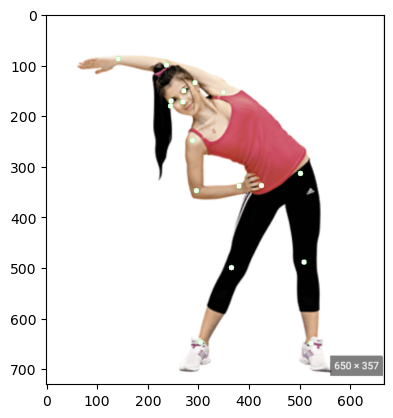

In [503]:
image = Image.open('./data/images/nahil_1.png')
plt.imshow(detector.draw_joints(image));

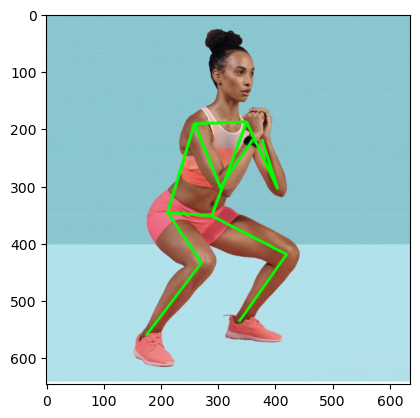

In [504]:
image = Image.open('./data/images/squat_1.jpeg')
plt.imshow(detector.draw_vectors(image));

___

___

## Video Processing

In [409]:
class ProcessedVideo:
    
    def __init__(self, path_to_video, detector, rate=1):
        self.positions_sequence = []
        self.frame_indexes = []
        self.rate = rate
        self.detector = detector
        self.process(path_to_video)
    
    def process(self, path_to_video, verbose=True):
        cap = cv2.VideoCapture(path_to_video)
        counter = -1
        if verbose:
            start = datetime.datetime.now()
            print(f"Start processing {path_to_video}...")
        while True:
            ret, frame = cap.read()
            counter = counter + 1
            if ret:
                if counter % self.rate == 0:
                    positions = self.detector.get_positions_array(frame)
                    normed_positions = [(y, x) for (x, y) in positions]
                    self.positions_sequence.append(normed_positions)  
                    self.frame_indexes.append(counter)
            else:
                break
        if verbose:
            print(f"Finished processing {path_to_video}. Took {datetime.datetime.now() - start} ms.")

In [610]:
# Loading some test videos

PATH_TO_COACH_VIDEO = '/Users/yelyzavetaboiarchuk/Desktop/diploma-videos/coach_1_ex.mp4'
PATH_USER_RIGHT_VIDEO = '/Users/yelyzavetaboiarchuk/Desktop/diploma-videos/person-ex-1.mov'
PATH_USER_WRONG_VIDEO = '/Users/yelyzavetaboiarchuk/Desktop/diploma-videos/person-ex-3.mov'
PATH_USER_WRONG_VIDEO2 = '/Users/yelyzavetaboiarchuk/Desktop/diploma-videos/person-ex-2.mov'

In [ ]:
coach_video = ProcessedVideo(PATH_TO_COACH_VIDEO, detector, rate=2)
user_ok_video = ProcessedVideo(PATH_USER_RIGHT_VIDEO, detector, rate=2)
user_bad_video = ProcessedVideo(PATH_USER_WRONG_VIDEO, detector, rate=2)

____

## Body comparison

In [43]:
def line_to_vector(line):
    return np.array([line[1][0] - line[0][0], line[1][1] - line[0][1]])

def compare_bodies(keypoints1, keypoints2, p=2):
    dist = 0
    for vec in VECTORS:
        vector1 = line_to_vector([keypoints1[vec[0].value], keypoints1[vec[1].value]])
        vector2 = line_to_vector([keypoints2[vec[0].value], keypoints2[vec[1].value]])
        dist += spatial.distance.cosine(vector1, vector2) ** p
    return dist / len(VECTORS)

Some examples

DISTANCE SCORE:
0.0012322966210417026


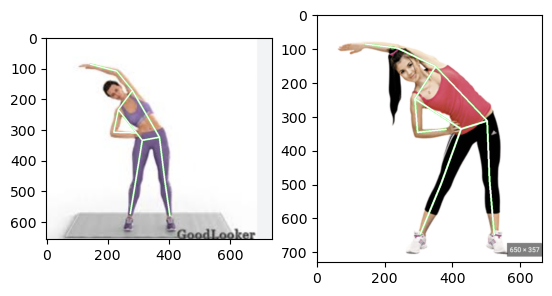

In [522]:
im1 = Image.open('./data/images/nahil_1.png')
im2 = Image.open('./data/images/nahil_2.png')

f, axarr = plt.subplots(1, 2)
axarr[1].imshow(detector.draw_vectors(np.array(im1)))
axarr[0].imshow(detector.draw_vectors(np.array(im2)));

similarity_score = compare_bodies(detector.get_positions_array(im1), detector.get_positions_array(im2))

print("DISTANCE SCORE:")
print(similarity_score)

DISTANCE SCORE:
0.06195860211320999


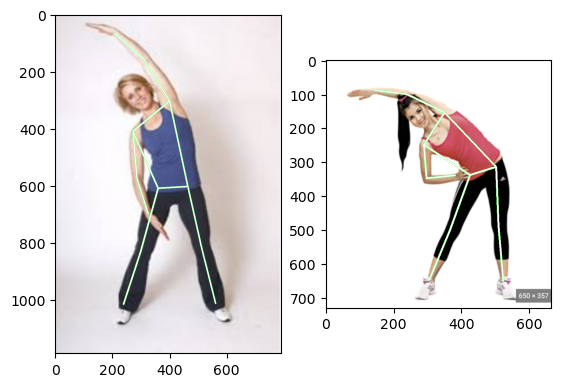

In [523]:
im1 = Image.open('./data/images/nahil_1.png')
im2 = Image.open('./data/images/nahil_3.png')

f, axarr = plt.subplots(1, 2)
axarr[1].imshow(detector.draw_vectors(np.array(im1)))
axarr[0].imshow(detector.draw_vectors(np.array(im2)));

similarity_score = compare_bodies(detector.get_positions_array(im1), detector.get_positions_array(im2))

print("DISTANCE SCORE:")
print(similarity_score)

DISTANCE SCORE:
0.4265719449501191


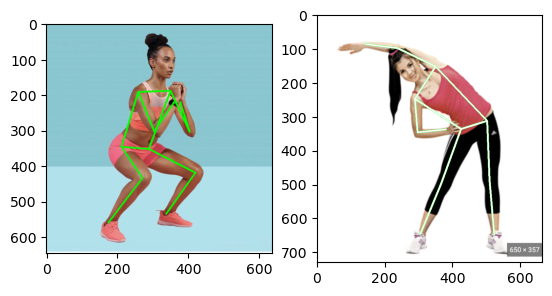

In [524]:
im1 = Image.open('./data/images/nahil_1.png')
im2 = Image.open('./data/images/squat_1.jpeg')

f, axarr = plt.subplots(1, 2)
axarr[1].imshow(detector.draw_vectors(np.array(im1)))
axarr[0].imshow(detector.draw_vectors(np.array(im2)));

similarity_score = compare_bodies(detector.get_positions_array(im1), detector.get_positions_array(im2))

print("DISTANCE SCORE:")
print(similarity_score)

___

## Frames Alignment

In [561]:
class Aligner:
    
    def __init__(self, target_sequence, waiting_window_len=25, coach_buffer_len=25, comparing_number=25):
        self.WAITING_WINDOW_LEN = waiting_window_len
        self.COACH_BUFFER_LEN = coach_buffer_len
        self.COMPARING_NUMBER = comparing_number
        self.target_sequence = target_sequence
        
    
    def prepare(self):
        self.user_sequence = []
        self.waiting_window = []
        self.waiting_window_indexes = []
        self.matched_coach_positions = []
        self.matched_user_positions = []
        self.matched_coach_indexes = []
        self.matched_user_indexes = []
        self.distances = []
        self.user_counter = 0
        self.coach_counter = 0
        self.frame_counter = 0
        self.last_distance = -1
        self.coach_ended = False
        # init coach buffer
        self.coach_buffer = self.target_sequence[:self.COACH_BUFFER_LEN]
        self.coach_buffer_indexes = list(range(self.COACH_BUFFER_LEN))
        self.coach_counter = self.COACH_BUFFER_LEN
        
    
    # imitate real-time frames receiving
    def receive(self, positions):
        
        if self.coach_ended:
            print("Target video reached the end.")
            return
        
        # wait until waiting window is filled
        if len(self.waiting_window) < self.WAITING_WINDOW_LEN:
            self.waiting_window.append(positions)
            self.waiting_window_indexes.append(self.user_counter)
            self.user_counter += 1
            return self.last_distance, False
        
        # align positions
        _, alligned = fastdtw(self.waiting_window, self.coach_buffer, dist=lambda a, b: compare_bodies(a, b))
        
        # find aligned frame in waiting_window which matches 1st position from coach_buffer
        position_match = int(np.median([x[0] for x in alligned if x[1] == 0]))

        # add aligned frames
        self.matched_coach_indexes.append(self.coach_buffer_indexes[0])
        self.matched_coach_positions.append(self.coach_buffer[0])
        self.matched_user_indexes.append(self.waiting_window_indexes[position_match])
        self.matched_user_positions.append(self.waiting_window[position_match])
        
        # calculate distance between last aligned frames
        distance, _ = fastdtw(self.matched_coach_positions[-self.COMPARING_NUMBER:],
                              self.matched_user_positions[-self.COMPARING_NUMBER:],
                              dist=lambda a, b: compare_bodies(a, b))
        self.distances.append(distance)
        self.last_distance = distance

        # move coach buffer for one position
        self.coach_buffer = self.coach_buffer[1:]
        self.coach_buffer.append(self.target_sequence[self.coach_counter])
        self.coach_buffer_indexes = self.coach_buffer_indexes[1:]
        self.coach_buffer_indexes.append(self.coach_counter)
        self.coach_counter += 1
        
        # move waiting window so as to cut everything before matched position
        self.waiting_window = self.waiting_window[position_match+1:]
        self.waiting_window.append(positions)
        self.waiting_window_indexes = self.waiting_window_indexes[position_match+1:]
        self.waiting_window_indexes.append(self.user_counter)
        self.user_counter += 1
        
        # if coach video is ended
        if self.coach_counter == len(self.target_sequence):
            self.coach_ended = True
            
        return distance, True

___

Some tests - display some matched positions from aligner

In [93]:
aligner = Aligner(coach_video.positions_sequence)
aligner.prepare()

[aligner.receive(p) for p in tqdm(user_ok_video.positions_sequence)]

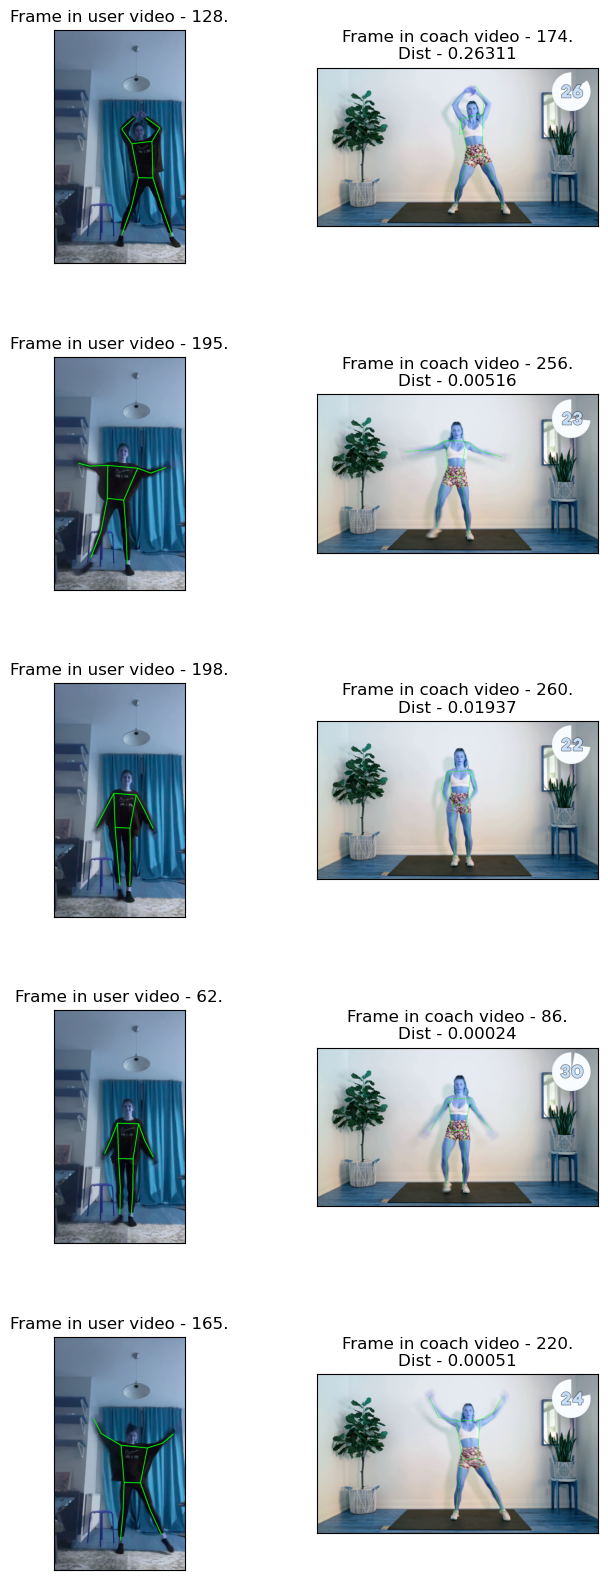

In [519]:
def swaps(r):
    return [(y, x) for (x, y) in r]

# number of random pairs to be displayed
N = 5

# to know where to show pics from
coach_vid = cv2.VideoCapture(PATH_TO_COACH_VIDEO)
user_vid = cv2.VideoCapture(PATH_USER_RIGHT_VIDEO)

# plot setup
random_frame_indexes = random.choices(list(range(len(aligner.matched_coach_indexes))), k=N)

num_rows, num_cols = len(random_frame_indexes), 2
element_width, element_height = 4, 4
fig_width, fig_height = num_cols * element_width, num_rows * element_height

f, axarr = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))


for (k, i) in enumerate(random_frame_indexes):
    (COACH, USER) = (int(aligner.matched_coach_indexes[i]*2), int(aligner.matched_user_indexes[i]))
    
    # bug in cv2 lib 
    if ((USER - 42 + 60) % 60 ) == 0:
        continue
    else:
        UN = USER*2 - ((USER - 42 + 60) // 60)
        
    coach_vid.set(1, COACH);
    _, frame1 = coach_vid.read()
    user_vid.set(1, UN);
    _, frame2 = user_vid.read()

    axarr[k, 1].imshow(detector.draw_vectors(frame1))
    axarr[k, 0].imshow(detector.draw_vectors(frame2))
    axarr[k, 1].set_xticks([])
    axarr[k, 1].set_yticks([])
    axarr[k, 0].set_xticks([])
    axarr[k, 0].set_yticks([])
    
    distance = compare_bodies(swaps(aligner.matched_coach_positions[i]), swaps(aligner.matched_user_positions[i]))
    axarr[k, 0].set_title(f"Frame in user video - {USER}.")
    axarr[k, 1].set_title(f"Frame in coach video - {COACH}.\nDist - {round(distance, 5)}")

f.subplots_adjust(hspace=0.4 , wspace=0.2)    

____

____

## Deviations highlighting

In [527]:
def get_deviated_vectors(keypoints1, keypoints2, t=0.01):
    vecs = []
    for i, vec in enumerate(VECTORS):
        vector1 = line_to_vector([keypoints1[vec[0].value], keypoints1[vec[1].value]])
        vector2 = line_to_vector([keypoints2[vec[0].value], keypoints2[vec[1].value]])
        dist = spatial.distance.cosine(vector1, vector2) ** 2
        if dist > t:
            vecs.append(i)
    return vecs

____

**Demo**

In [606]:
def play(benchmark_v, user_v, target_sequence):
    
    benchmark_cam = cv2.VideoCapture(benchmark_v)
    user_cam = cv2.VideoCapture(user_v)
    aligner = Aligner(coach_video.positions_sequence)
    aligner.prepare()
    
    result_ready = False
    frame_counter = -1
    rate = 2
    label = "...."
    good_color = (90, 241, 25)
    color = good_color
    bad_color = (253, 5, 5)
    last_deviated = []
    
    while (benchmark_cam.isOpened() or user_cam.isOpened()):

        u_val, u_image = user_cam.read()
        b_val, b_image = benchmark_cam.read()
        frame_counter = frame_counter + 1
        
        if u_val and b_val:
            if frame_counter % rate == 0:
                if frame_counter >= user_cam.get(cv2.CAP_PROP_FRAME_COUNT) or frame_counter >= benchmark_cam.get(cv2.CAP_PROP_FRAME_COUNT):
                    break

                winname = "User Video"
                cv2.namedWindow(winname)   
                cv2.moveWindow(winname, 720, -100) 

                if u_val or b_val:
                    positions = list(swaps(detector.get_positions_array(u_image)))
                    error, result_ready = aligner.receive(positions)
                    if error < 2 and result_ready:
                        label = 'Nice!'
                        color = good_color
                        last_deviated = []
                    elif error >= 2 and result_ready:
                        label  = 'Bad!'
                        color = bad_color
                        deviated = last_deviated = get_deviated_vectors(aligner.matched_coach_positions[-1], aligner.matched_user_positions[-1])
                    elif not result_ready:
                        label  = '...'
                    u_image = detector.draw_vectors(u_image, positions=swaps(positions), deviated=last_deviated)
                    cv2.putText(u_image, label.upper(), (40, 600),cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
                    b_image = cv2.resize(b_image, dsize=(int(b_image.shape[1] * u_image.shape[0] / b_image.shape[0]) , u_image.shape[0]))
                    numpy_horizontal = np.hstack((b_image, u_image))
                    cv2.imshow('Video', numpy_horizontal) 
                    if cv2.waitKey(1) & 0xFF == ord('q'):
                            break
        else:
            break
        cv2.destroyAllWindows()

In [608]:
play(
    PATH_TO_COACH_VIDEO, 
    PATH_USER_RIGHT_VIDEO, 
    coach_video.positions_sequence
)

In [611]:
play(
    PATH_TO_COACH_VIDEO, 
    PATH_USER_WRONG_VIDEO, 
    coach_video.positions_sequence
)

In [612]:
play(
    PATH_TO_COACH_VIDEO, 
    PATH_USER_WRONG_VIDEO2, 
    coach_video.positions_sequence
)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/Users/yelyzavetaboiarchuk/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/_l/4mdx640d5f797fyvbccxlv1r0000gp/T/ipykernel_21444/2621949367.py", line 1, in <module>
    play(
  File "/var/folders/_l/4mdx640d5f797fyvbccxlv1r0000gp/T/ipykernel_21444/2816800625.py", line 34, in play
    error, result_ready = aligner.receive(positions)
  File "/var/folders/_l/4mdx640d5f797fyvbccxlv1r0000gp/T/ipykernel_21444/2567113997.py", line 57, in receive
    distance, _ = fastdtw(self.matched_coach_positions[-self.COMPARING_NUMBER:],
  File "fastdtw/_fastdtw.pyx", line 86, in fastdtw._fastdtw.fastdtw
  File "fastdtw/_fastdtw.pyx", line 114, in fastdtw._fastdtw.__fastdtw
  File "fastdtw/_fastdtw.pyx", line 118, in fastdtw._fastdtw.__fastdtw
  File "fastdtw/_fastdtw.pyx", line 303, in fastdtw._fastdtw.__dtw
  File "/var/folders/_l/4mdx640

TypeError: object of type 'NoneType' has no len()